# Assignment 1 

Elinor Funk, Leland Whitlock, Marlo Anzarut 

github: https://github.com/elinorfunk/compsoc_assignment1


### Part 1

In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os 

In [3]:
page = requests.get('https://ic2s2-2023.org/program')
bs = BeautifulSoup(page.content)
italics = bs.find_all('i')
name_list = []
for i in italics:
    names = i.get_text()
    clean_names = names.replace("Chair:", "")
    name_list += clean_names.split(', ')

In [4]:
for i in range(len(name_list)):
    name_list[i] = name_list[i].strip()
    name_list[i] = name_list[i].lower()

In [5]:
name_df = pd.DataFrame(name_list, columns=['names'])
no_dupes = name_df.drop_duplicates(keep='first', ignore_index=True)

In [6]:
no_dupes.to_csv("data/names.csv")

### Part 2 - Ready Made vs Custom Made Data 

1. Advantages with custom-made data are that you can control the sample: meaning that you can make sure that the participants in the experiment are mixed in gender, age, etc. You can also customize the specific questions that you want answered. However, there are disadvantages with experiments like this. For example, maybe only a subset of individuals choose to answer surveys, which can bias the data. In addition, it is costly to arrange experiments or surveys. 

An advantage with ready-made data is that you can easily get a large sample without it being as costly as arranging an experiment. As well, you can capture real world behavior, since the participants are not aware that their data will be tracked. A disadvantage is that the sample of people might be biased, it might only be a certain type of people that uses this fitness tracking app. 

2. As mentioned in the lecture videos, the results of the second study might be biased since you are more likely to be friends with people acting in a similar manner as you: for example if you like running on Saturdays, you may be more likely to befriend people who also enjoy running on Saturdays, and it is not a result of contagion. 

As for the first study, the participants might be more interested in registering to the health website just because the participants are aware that their behavior is monitored in an experiment. 


In [7]:
# read author data from week 2, exercise 2
wd = os.getcwd()
data = wd[:wd.rfind("\\")] + "\\data"
data = data.replace("\\", "/")

part_one = pd.read_csv(f"authorsw1.csv")
#part_two = pd.read_csv(f"{data}/part_two_info_2.csv")
#complete_list = pd.concat([part_one, part_two], ignore_index=True)

final_df = part_one.drop('Unnamed: 0', axis=1)

display(final_df)

,id,display_name,works_api_url,works_count,h_index,country_code
0,https://openalex.org/A5037267743,Claudia Wagner-Riddle,https://api.openalex.org/works?filter=author.i...,113,37,CA
1,https://openalex.org/A5031780796,Jonas L. Juul,https://api.openalex.org/works?filter=author.i...,23,5,US
2,https://openalex.org/A5055710645,Jon Kleinberg,https://api.openalex.org/works?filter=author.i...,581,97,US
3,https://openalex.org/A5056247832,Chloe Ahn,https://api.openalex.org/works?filter=author.i...,4,1,US
4,https://openalex.org/A5040523461,Xinyi Wang,https://api.openalex.org/works?filter=author.i...,1772,57,CN
...,...,...,...,...,...,...
1376,https://openalex.org/A5059015114,Coen D. Needell,https://api.openalex.org/works?filter=author.i...,3,2,US
1377,https://openalex.org/A5084148692,Elliot E. Pickens,https://api.openalex.org/works?filter=author.i...,2,1,GB
1378,https://openalex.org/A5054707908,David Rothschild,https://api.openalex.org/works?filter=author.i...,125,21,US
1379,https://openalex.org/A5056216760,Anna George,https://api.openalex.org/works?filter=author.i...,149,29,US


### Filtering/Works Requests


In [8]:
# remove authors with works_count < 5, > 5000
non_contributors = final_df[(final_df.works_count < 5) | (final_df.works_count > 5000)].index
pmos = final_df.drop(non_contributors)
pmos = pmos.reset_index()

In [9]:
# create the request url with the given authors and filters
def build_request(author_ids, cursor="*"):
    auth = "author.id:"
    for id in author_ids:
        auth += f"{id}|"
    auth = auth[:-1]


    concept_filter = "concept.id:https://openalex.org/C17744445|https://openalex.org/C144024400|https://openalex.org/C15744967|https://openalex.org/C162324750,concept.id:https://openalex.org/C121332964|https://openalex.org/C41008148|https://openalex.org/C33923547"
    url = f"https://api.openalex.org/works?per-page=200&cursor={cursor}&filter={auth},{concept_filter},cited_by_count:>10,authors_count:<10"
    return url

In [10]:
# get a list of the authors used in the filter given a start index (max 25)
def get_authors(start):
    query_list = []
    if start + 24 > len(pmos):
        end = len(pmos) - 1
    else:
        end = start + 24
    for i in pmos.loc[start:end]["id"]:
        id = i[i.find('A'):]
        query_list.append(id)
    return query_list

In [11]:
# parse the json of a work item in the html response
def get_work_row(item):
    id = item['id']
    pub_year = item['publication_year']
    cite_count = item['cited_by_count']
    authors = [item['authorships'][a]['author'].get('id') for a in range(len(item['authorships']))]
    title = item['title']
    aii = item['abstract_inverted_index']
    
    return [id, pub_year, cite_count, authors, title, aii]

In [12]:
# refactor
works_df = pd.DataFrame(columns=['id', 'publication_year', 'cited_by_count', 'author_ids', 'title', 'abstract_inverted_index'])


In [13]:
# fetch the next batch of results using the batch # (counter)
def fetch_results(counter):
    next_cursor = '*'

    while (next_cursor):
        # form request url
        r = build_request(get_authors(counter * 25), next_cursor)
        response = requests.get(r)
        if not response:
            break
        rjson = response.json()

        # set next_cursor for paging
        next_cursor = rjson['meta'].get('next_cursor')
        
        # add results of response to works_df if two two relevant concepts are found 
        for work in rjson['results']:
            work_row = get_work_row(work)
            if work_row[0] not in works_df["id"].values: 
                works_df.loc[len(works_df.index)] = work_row
                       
    

In [15]:
# get the works dataset by fetching all authors
for i in range(45):
    fetch_results(i)

works_df.drop_duplicates(subset='title')

,id,publication_year,cited_by_count,author_ids,title,abstract_inverted_index
0,https://openalex.org/W2127048411,2010,7467,[https://openalex.org/A5053938061],Community detection in graphs,"{'The': [0], 'modern': [1], 'science': [2], 'o..."
1,https://openalex.org/W2058105398,2009,3325,"[https://openalex.org/A5031236554, https://ope...",Statistical physics of social dynamics,"{'Statistical': [0], 'physics': [1, 79], 'has'..."
2,https://openalex.org/W3142588439,2010,2176,"[https://openalex.org/A5017669758, https://ope...","Networks, Crowds, and Markets","{'Are': [0, 30], 'all': [1, 32], 'film': [2], ..."
3,https://openalex.org/W2116926372,2012,1762,"[https://openalex.org/A5017914184, https://ope...",Misinformation and Its Correction,"{'The': [0], 'widespread': [1], 'prevalence': ..."
4,https://openalex.org/W2147453867,2006,1719,"[https://openalex.org/A5058815871, https://ope...",Experimental Study of Inequality and Unpredict...,"{'Hit': [0], 'songs,': [1], 'books,': [2], 'an..."
...,...,...,...,...,...,...
9471,https://openalex.org/W155200242,2010,11,"[https://openalex.org/A5045037642, https://ope...",“You’re as Sick as You Sound”: Using Computati...,"{'Recently,': [0], 'researchers': [1], 'in': [..."
9472,https://openalex.org/W170385551,2010,11,"[https://openalex.org/A5089575055, https://ope...",Predicting Human-Targeted Translation Edit Rat...,"{'In': [0, 102], 'the': [1, 20, 34, 42, 52, 99..."
9473,https://openalex.org/W105761736,1990,17,[https://openalex.org/A5045037642],Using discourse context to guide pitch accent ...,None
9474,https://openalex.org/W2003425297,2007,12,[https://openalex.org/A5065243448],Remarks on ghost projections and ideals in the...,None


In [16]:
display(works_df)

,id,publication_year,cited_by_count,author_ids,title,abstract_inverted_index
0,https://openalex.org/W2127048411,2010,7467,[https://openalex.org/A5053938061],Community detection in graphs,"{'The': [0], 'modern': [1], 'science': [2], 'o..."
1,https://openalex.org/W2058105398,2009,3325,"[https://openalex.org/A5031236554, https://ope...",Statistical physics of social dynamics,"{'Statistical': [0], 'physics': [1, 79], 'has'..."
2,https://openalex.org/W3142588439,2010,2176,"[https://openalex.org/A5017669758, https://ope...","Networks, Crowds, and Markets","{'Are': [0, 30], 'all': [1, 32], 'film': [2], ..."
3,https://openalex.org/W2116926372,2012,1762,"[https://openalex.org/A5017914184, https://ope...",Misinformation and Its Correction,"{'The': [0], 'widespread': [1], 'prevalence': ..."
4,https://openalex.org/W2147453867,2006,1719,"[https://openalex.org/A5058815871, https://ope...",Experimental Study of Inequality and Unpredict...,"{'Hit': [0], 'songs,': [1], 'books,': [2], 'an..."
...,...,...,...,...,...,...
9471,https://openalex.org/W155200242,2010,11,"[https://openalex.org/A5045037642, https://ope...",“You’re as Sick as You Sound”: Using Computati...,"{'Recently,': [0], 'researchers': [1], 'in': [..."
9472,https://openalex.org/W170385551,2010,11,"[https://openalex.org/A5089575055, https://ope...",Predicting Human-Targeted Translation Edit Rat...,"{'In': [0, 102], 'the': [1, 20, 34, 42, 52, 99..."
9473,https://openalex.org/W105761736,1990,17,[https://openalex.org/A5045037642],Using discourse context to guide pitch accent ...,None
9474,https://openalex.org/W2003425297,2007,12,[https://openalex.org/A5065243448],Remarks on ghost projections and ideals in the...,None


Data Overview and Reflection questions: 

- Dataset summary: 
    The dataset obtained is including around 9,300 articles.

- Efficiency in code: 
    To make out code more efficient we implemented searching for the authors and articles in batches of 25. In addition, the paging limit was increased from 25 to 200 works per request as suggested in the instructions and we applied the filters directly in the request url.  

- Filtering Criteria and Dataset Relevance: 
    A primary reason for filtering is to decrease the amount of collected data, and increase efficiency of the code. By filtering on citation count, we compile the most recognized and influential articles to our dataset. By setting specific thresholds for the total number of works by an author we reaffirm that the data collected is the most relevant. With this approach, new authors in the field might be underrepresented in the dataset. The filtering criteria for the concepts on the other hand is necessary to achieve our desired outcome - to collect articles for authors in the field of Computational Social Science. 


### Part 4 

In [17]:
import networkx as nx
import itertools

In [160]:
def count_papers(author_id, authors_ids_list): 
    author1 = author_id[0]
    author2 = author_id[1]
    count = sum(1 for article in authors_ids_list if author1 in article and author2 in article)
    return count 

def create_weighted_egdes(papers, graph): 
    w_edge_list = [] 
    authors_ids = papers["author_ids"].to_list()
    for author_id in authors_ids: 
        # If only one author, add single node, if that would be requested 
        # if len(author_id) == 1: 
        #     graph.add_nodes_from(author_id[0])

         # If there are only two authors 
        if len(author_id) == 2 and author_id not in w_edge_list:
            # Find how many times the author pair appears in list of author ids
            papers_nr = count_papers(author_id, authors_ids) 
            w_edge_list.append((author_id[0], author_id[1], papers_nr))

        # If more than 2 - compute all combinations of authors 
        if len(author_id) > 2: 
            combinations = list(itertools.combinations(author_id, 2))
            for combination in combinations: 
                if combination not in w_edge_list:
                    # Find how many times the author pair appears in list of author ids
                    papers_nr = papers_nr = count_papers(combination, authors_ids) 
                    w_edge_list.append((combination[0], combination[1], papers_nr))
    return w_edge_list, graph 
            
    

In [161]:
# Create graph and add egdes 

graph = nx.Graph()
weighted_egdes, graph = create_weighted_egdes(works_df, graph)
graph.add_weighted_edges_from(weighted_egdes)

In [102]:
print(f"The total number of links in the graph is {len(weighted_egdes)}")
print(f"The total number of egdes in the graph is {len(graph)}")

The total number of links in the graph is 64521
The total number of egdes in the graph is 14989


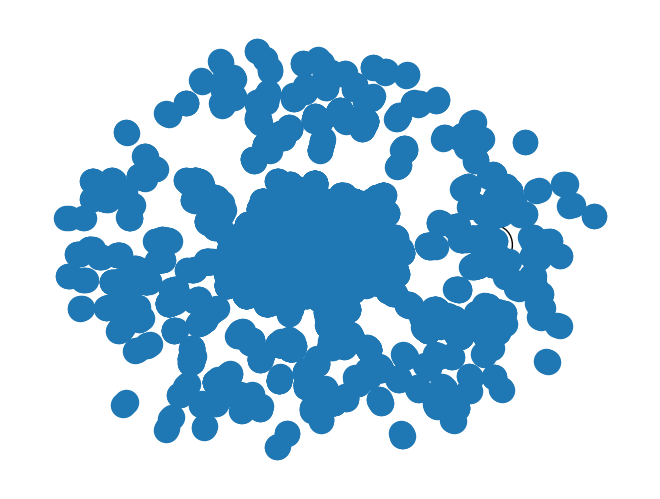

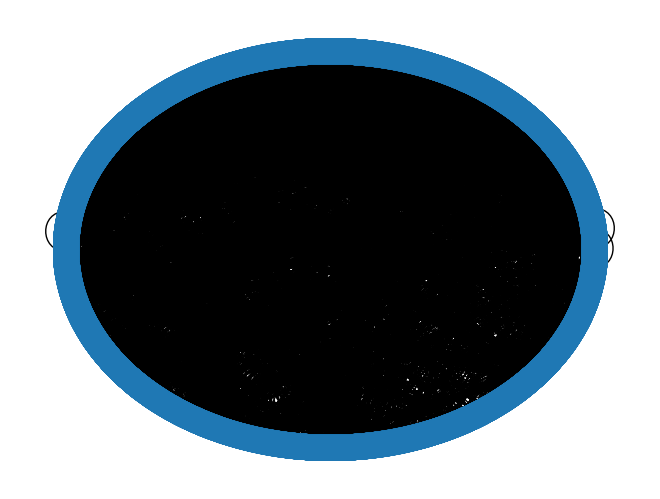

In [146]:
# Display graph 
import matplotlib.pyplot as plt 

nx.draw(graph)
plt.show()
nx.draw(graph, pos=nx.circular_layout(graph))
plt.show()

In [155]:
# Find the number of connected nodes 
print(f"Number of connected components is {len(list(nx.connected_components(graph)))}")
print(f"Number of isolated nodes is {len(graph) - len(list(nx.connected_components(graph)))}")

Number of connected components is 236
Number of isolated nodes is 14753


In [138]:
# Compute median etc for the degrees 
import numpy as np 

graph_degrees = graph.degree()
degrees = [degree for author, degree in graph_degrees]
sum_degrees = sum(degrees)

print(f"The average degree is {sum_degrees/len(graph_degrees)}") 
print(f"The maximum degree is {max(degrees)}") 
print(f"The minimum degree is {min(degrees)}") 
print(f"The median degree is {np.median(degrees)}") 
print(f"The mode of the degree is {np.argmax(np.bincount(degrees))}")


The average degree is 6.311962105544065
The maximum degree is 198
The minimum degree is 1
The median degree is 5.0
The mode of the degree is 3


In [162]:
# Compute median etc for the weighted degrees  
node_strength = [sum(data["weight"] for _, _, data in graph.edges(node, data=True)) for node in graph]
sum_node_strength = sum(node_strength)

print(f"The average weighted degree is {sum_node_strength/len(node_strength)}") 
print(f"The maximum weigthed degree is {max(node_strength)}") 
print(f"The minimum weigthed degree is {min(node_strength)}") 
print(f"The median weigthed degree is {np.median(node_strength)}") 
print(f"The mode of the weighted degree is {np.argmax(np.bincount(node_strength))}")

The average weighted degree is 8.609780505704183
The maximum weigthed degree is 476
The minimum weigthed degree is 1
The median weigthed degree is 5.0
The mode of the weighted degree is 3


In [145]:
# Find top authors 

sorted_degrees = sorted(graph_degrees, key=lambda x: x[1], reverse=True)
top_authors = [author for author, degree in sorted_degrees[:5]]
top_authors_names = final_df[final_df["id"].isin(top_authors)]["display_name"].to_list()

print(f"Top authors are: {i}" for i in top_authors_names)



Top authors are: ['Stephan Lewandowsky', 'Lyle H. Ungar', 'Jonathan D. Cohen', 'Qin Li', 'Qin Wang']


In [149]:
# Display data about top authors 

display(final_df[final_df["id"].isin(top_authors)])

,id,display_name,works_api_url,works_count,h_index,country_code
12,https://openalex.org/A5017914184,Stephan Lewandowsky,https://api.openalex.org/works?filter=author.i...,539,71,GB
40,https://openalex.org/A5044944954,Lyle H. Ungar,https://api.openalex.org/works?filter=author.i...,525,65,US
710,https://openalex.org/A5088141761,Jonathan D. Cohen,https://api.openalex.org/works?filter=author.i...,736,130,IT
1230,https://openalex.org/A5075080019,Qin Li,https://api.openalex.org/works?filter=author.i...,3695,98,CN
1330,https://openalex.org/A5065243448,Qin Wang,https://api.openalex.org/works?filter=author.i...,4352,120,CN


- Stephan Lewandowsky is a psychologist with an interest in computational modeling. 

- Lyle H. Ungar develops machine learning models etc for psychology and medical research. 

- Jonathan D. Cohen is a psychologist but does not seem to much be connected to modelling, data science or similar. 

- Qin Li seems to be in the field of medicine/chemistry/physics and not much connected to social science or economy or similar. 
- Qin Wang is in medicine and biology, and does not seem to have a lot of connections to social science subjects. 

A possible reason that the last three authors are not obviously connected to computational social science may be that since they have published a substantial number of articles, some or just one of them might be connected to both social science fields and physics/mathematics/computer science. The concepts ids are filtering on the articles, and not on the authors, so some authors might have their articles connected to computational social science, even though that is not their main field. 